In [1]:
!pip install tensorflow
import pandas as pd ##pip install pandas
import numpy as np #pip install numpy
import os
import matplotlib.pyplot as plt ##pip install matplotlib.pyplot
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf ##pip install tensorflow
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import tensorflow as tf

# Old
default_graph = tf.get_default_graph()

# Updated
default_graph = tf.compat.v1.get_default_graph()


Defaulting to user installation because normal site-packages is not writeable



In [32]:
TRAIN_DIR = 'faceemotion/train/'
TEST_DIR ='faceemotion/test/'

In [33]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [34]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,faceemotion/train/fear\Training_39556293.jpg,fear
1,faceemotion/train/neutral\Training_18027640.jpg,neutral
2,faceemotion/train/sad\Training_53938028.jpg,sad
3,faceemotion/train/happy\Training_19761099.jpg,happy
4,faceemotion/train/surprise\Training_19773644.jpg,surprise


In [35]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
    
    return image_paths, labels


In [36]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,faceemotion/train/surprise\Training_75715301.jpg,surprise
1,faceemotion/train/surprise\Training_34816756.jpg,surprise
2,faceemotion/train/angry\Training_31625396.jpg,angry
3,faceemotion/train/fear\Training_89356500.jpg,fear
4,faceemotion/train/surprise\Training_54384400.jpg,surprise


In [37]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,faceemotion/test/angry\PrivateTest_10131363.jpg,angry
1,faceemotion/test/angry\PrivateTest_10304478.jpg,angry
2,faceemotion/test/angry\PrivateTest_1054527.jpg,angry
3,faceemotion/test/angry\PrivateTest_10590091.jpg,angry
4,faceemotion/test/angry\PrivateTest_1109992.jpg,angry


In [42]:
print(train['label'].dtype)

object


In [43]:
train['label'] = train['label'].astype('category')

<Axes: ylabel='label'>

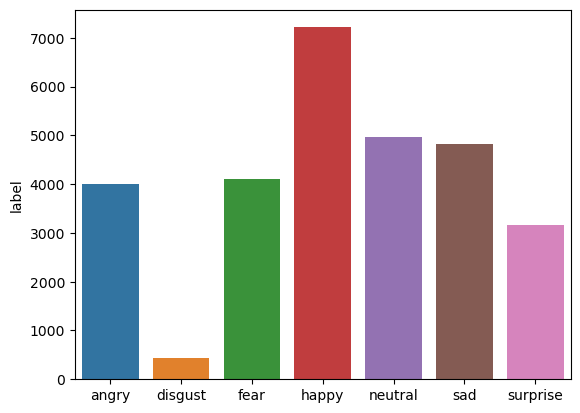

In [45]:
label_counts = train['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts)

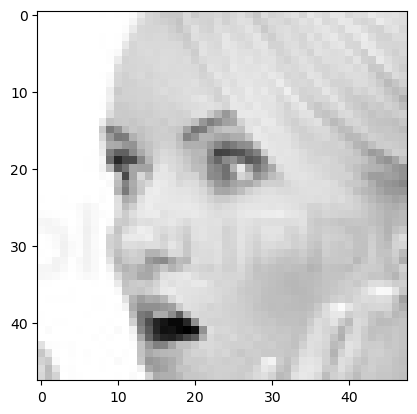

In [46]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

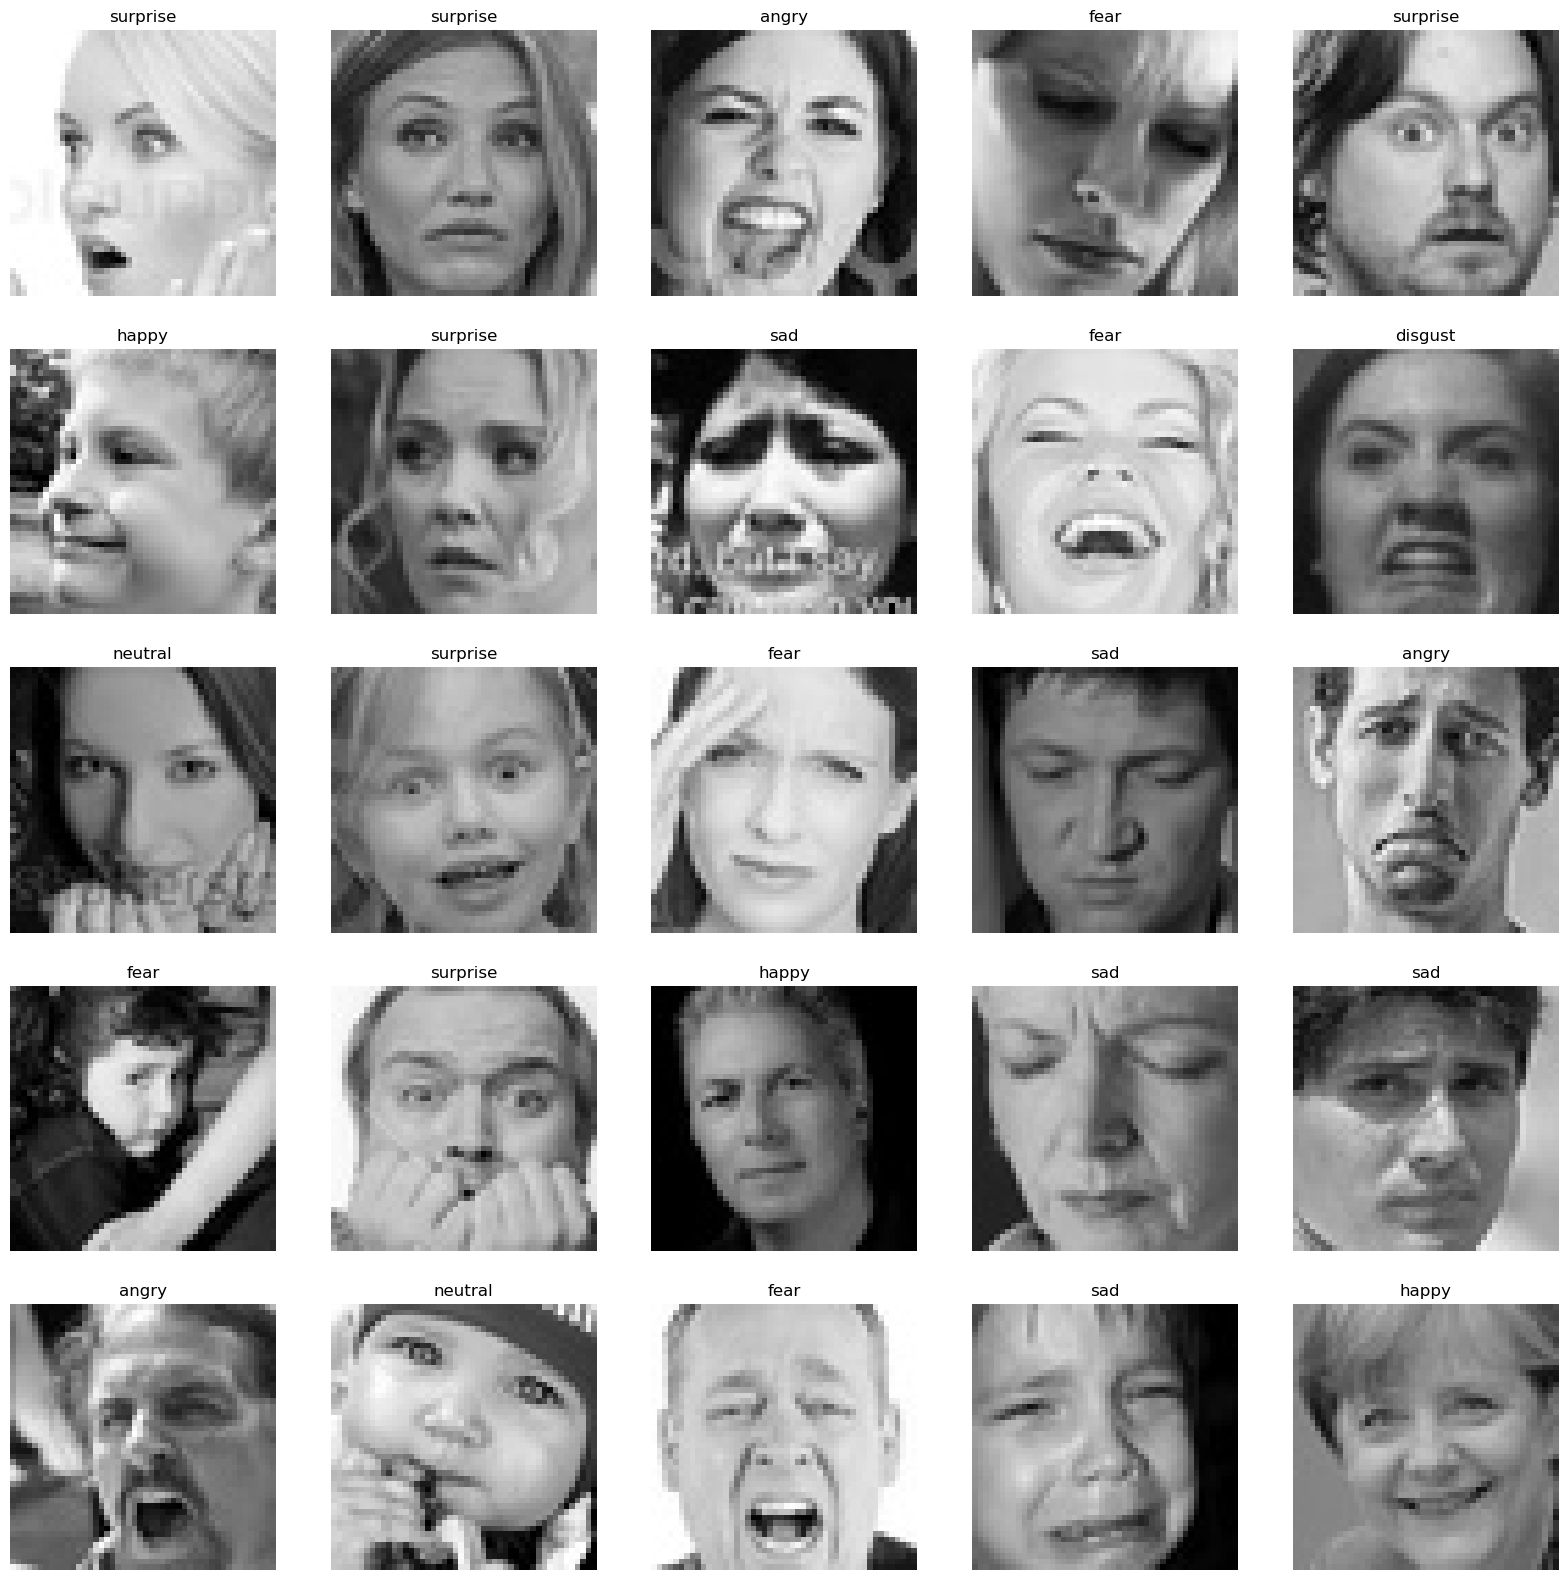

In [47]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [48]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [49]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [50]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [51]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [52]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [53]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7) 

In [54]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [55]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [56]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [57]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


225/225 [==============================] - 236s 1s/step - loss: 1.8241 - accuracy: 0.2466 - val_loss: 1.8267 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 223s 991ms/step - loss: 1.7837 - accuracy: 0.2609 - val_loss: 1.7016 - val_accuracy: 0.3083
Epoch 3/100
225/225 [==============================] - 227s 1s/step - loss: 1.6503 - accuracy: 0.3389 - val_loss: 1.4915 - val_accuracy: 0.4244
Epoch 4/100
225/225 [==============================] - 248s 1s/step - loss: 1.5225 - accuracy: 0.4055 - val_loss: 1.4078 - val_accuracy: 0.4450
Epoch 5/100
225/225 [==============================] - 249s 1s/step - loss: 1.4502 - accuracy: 0.4406 - val_loss: 1.3602 - val_accuracy: 0.4826
Epoch 6/100
225/225 [==============================] - 241s 1s/step - loss: 1.4000 - accuracy: 0.4580 - val_loss: 1.2847 - val_accuracy: 0.5038
Epoch 7/100
225/225 [==============================] - 245s 1s/step - loss: 1.3536 - accuracy: 0.4800 - val_loss: 1.2610 - val_accu

225/225 [==============================] - 222s 986ms/step - loss: 0.9057 - accuracy: 0.6612 - val_loss: 1.0299 - val_accuracy: 0.6124
Epoch 55/100
225/225 [==============================] - 223s 992ms/step - loss: 0.8996 - accuracy: 0.6631 - val_loss: 1.0285 - val_accuracy: 0.6156
Epoch 56/100
225/225 [==============================] - 223s 990ms/step - loss: 0.8924 - accuracy: 0.6710 - val_loss: 1.0363 - val_accuracy: 0.6160
Epoch 57/100
225/225 [==============================] - 246s 1s/step - loss: 0.8894 - accuracy: 0.6689 - val_loss: 1.0224 - val_accuracy: 0.6190
Epoch 58/100
225/225 [==============================] - 284s 1s/step - loss: 0.8792 - accuracy: 0.6740 - val_loss: 1.0262 - val_accuracy: 0.6128
Epoch 59/100
225/225 [==============================] - 223s 992ms/step - loss: 0.8723 - accuracy: 0.6740 - val_loss: 1.0318 - val_accuracy: 0.6170
Epoch 60/100
225/225 [==============================] - 221s 985ms/step - loss: 0.8679 - accuracy: 0.6797 - val_loss: 1.0279 - val_

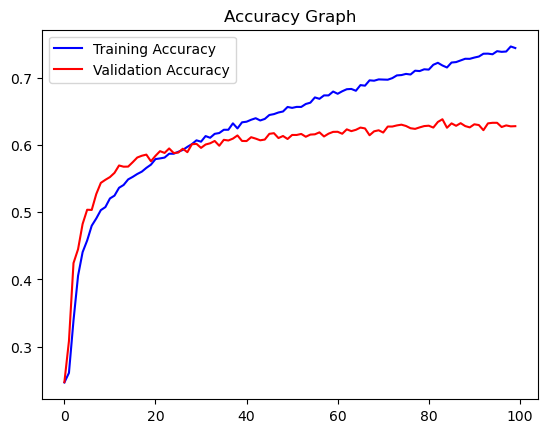

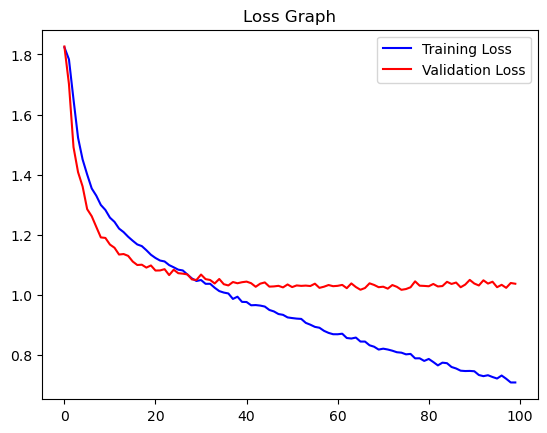

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Original Output: sad
1/1 [==============================] - 0s 68ms/step
Predicted Output: sad


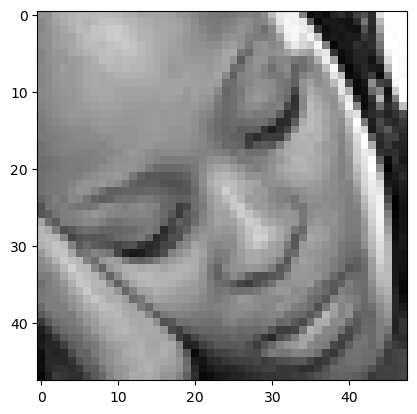

In [67]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
1/1 [==============================] - 0s 36ms/step
Predicted Output: fear


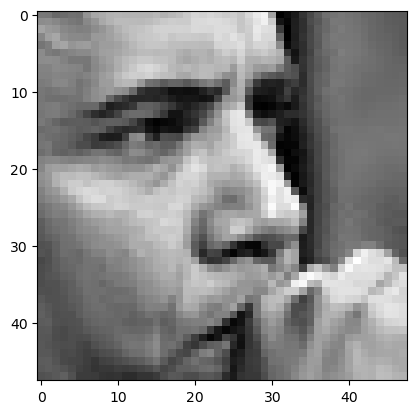

In [65]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: surprise
1/1 [==============================] - 0s 71ms/step
Predicted Output: surprise


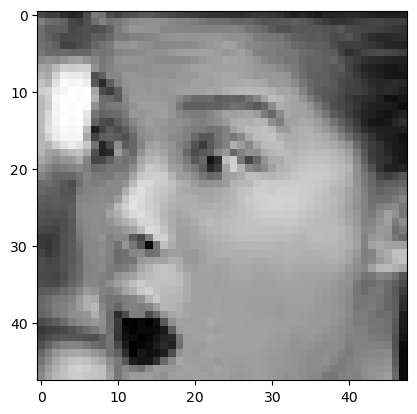

In [71]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');